In [1]:
import skimage.io as io
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import logging
warnings.filterwarnings("ignore")  # skimage warns when saving uint16 with not covering full range of 0-65535
example_root = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'examples')

___Set up Logger___

In [2]:
logger = logging.getLogger('pcna')
logger.setLevel(logging.DEBUG)
handler1 = logging.StreamHandler()
handler1.setLevel(logging.INFO)
logger.addHandler(handler1)

---

## Train an SVM classifier to associate mitotic tracks
### Author: Yifan Gui @ KuanYoow Chan group

After nuclear envelope breakdown, PCNA protein flees out into the cytoplasm, leading to dim signal intensity during mitosis. Additionally, the rounding cell are usually hard to be captured by the microscopy within focus limit. To reconstruct mitosis event from tracking results, pcnaDeep offers two algorithms: __spatial/temporal threshold-based assocation__ and __SVM-based classifier__. The first requires no training and totally depends on thresholding setting (see [Getting_started](Getting_started.ipynb)), while the second __SVM classifier__ requires a small training set and may perform better with large heterogenity of the cell.

__SVM feature extractor__ in pcnaDeep is implemented as a class method `pcnaDeep.refiner.Refiner.get_SVM_train( )` that is able to extract SVM feature map under either `TRAIN_GT` or `TRAIN` mode. You can select based on what kind of input is available.

___Inputs to generate SVM training data___ &emsp;&emsp; (_we discuss outputs of `get_SVM_train()` in Section 2_)

1. Tracked object table (GT including mitosis relationship). 👈 __`TRAIN_GT`__ mode. Section 1a


2. Tracked object table (either GT or not) + mitosis lookup `txt`. 👈 __`TRAIN`__ mode. Section 1b

---

### 1a. Extract mitosis ground truth `array` directly from GT tracked object table -- `TRAIN_GT` mode

If your tracked object table includes ground truth of mitosis relationship, you can directly call __`Refiner.get_SVM_train( )`__. The method will check `parentTrackId` column in the table to recognize mitosis relationships. Doing such on non-GT table is dangerous since potential positive instances will be regarded as negative.

Remember to set the following meta-parameters so that our `Refiner` knows how to normalize data.
- __`sample_freq`__ (frame per minute);
- __`mt_len`__ (frame) estimated mitosis length.

In [3]:
from pcnaDeep.refiner import Refiner
dt = pd.read_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_tracks_GT_full.csv'))
r = Refiner(dt.copy(), mode='TRAIN_GT', minM=1, sample_freq=1/20, mt_len=5)

{'mt_len': 5, 'sample_freq': 0.05, 'meanDisplace': 10.571116225550751}
Mean size: 76.41107503064248


In [4]:
X, y, samples = r.doTrackRefine()

Mitosis exit not found for daughter: 124
Mitosis exit not found for daughter: 132
Mitosis exit not found for daughter: 160
Mitosis exit not found for daughter: 184
High quality tracks subjected to predict relationship: 99
Generating SVM samples from mitosis-broken tracked object table.
41 samples drawn from tracked object table.
Extracting features...
Considered 500/1504 cases.
Considered 1000/1504 cases.
Finished feature extraction: 649 samples.


---

### 1b. Generate _mitosis lookup_ `.txt` from model output -- `TRAIN` mode
All features fed into pcnaDeep SVM classifier is extracted from the __tracked object table__, i.e., one of the standard outputs of the model ends with __`_tracks.csv`__.  Therefore, it is convinent to start with this file. In this tutorial, we will play with the file `example/MCF10A/10A_cpd_tracks_GT_noM.csv`. The file names tells this tracked object table does not contain mitosis relationships.

_Note:_ __Do not__ start with refined table (ends with `_refined.csv`) where mitosis information has already been predicted.

In [2]:
dt = pd.read_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_tracks_GT_noM.csv'))
dt

,Unnamed: 0,frame,trackId,lineageId,parentTrackId,Center_of_the_object_1,Center_of_the_object_0,predicted_class,Probability of G1/G2,Probability of S,Probability of M,continuous_label,major_axis,minor_axis,mean_intensity,emerging,background_mean,BF_mean,BF_std
0,0,0,1,1,0,14.870822,425.774164,S,0,1,0,1,82.920799,36.572696,148.540650,0,26.360563,126.138663,37.481392
1,76,1,1,1,0,19.041292,439.863137,S,0,1,0,4,92.452418,44.550738,131.646687,0,24.297872,129.554113,34.466815
2,150,2,1,1,0,24.161390,444.094025,S,0,1,0,4,100.336281,56.368319,125.949060,0,24.348948,121.808379,34.208668
3,225,3,1,1,0,27.079906,432.878329,S,0,1,0,2,97.287518,63.382501,130.443213,0,30.539299,118.404645,33.323533
4,305,4,1,1,0,24.326324,428.842665,S,0,1,0,1,90.938206,57.145022,124.473017,0,37.383513,128.902711,31.516612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5356,5144,63,162,162,0,437.873684,610.110526,G1/G2,1,0,0,27,57.980703,38.159348,206.819883,0,32.299578,157.157310,48.911226
5357,5225,64,162,162,0,438.639163,611.216153,G1/G2,1,0,0,27,57.037676,39.052081,210.405578,0,38.607516,159.740848,53.146386
5358,5151,63,163,163,0,513.168726,1033.574776,M,0,0,1,34,58.523991,51.364389,67.253941,0,37.347162,211.226246,54.948653
5359,5230,64,163,163,0,518.664538,1048.206157,M,0,0,1,32,81.624698,68.777094,74.019384,0,57.581454,132.044698,61.648130


### &emsp;1b.1 Generate mitosis-broken table
pcnaDeep SVM takes in inputs extracted from __track A__ and __track B__ and outputs __the confidence that track A is the mother of track B__. This requires each track does not includes any entire mitosis events, which is accomplished in the first step of normal track refinement by a class method of `pcnaDeep.refiner.Refiner` named __`break_mitosis( )`__, which implements a greedy phase resolving algorithm throughout the track. Such operation should be recursively performed to break any possible mitosis events.

The above process can be automatically completed through calling `pcnaDeep.refiner.Refiner.doTrackRefine( )` in a `Refiner` object initialized under `TRAIN` mode. The method returns the tracked object table with all mitosis broken, as well as the standard mitosis relationship dictionary `{parent ID: {'div': int, 'daug':{daughter ID: {'mitosis exit':int, 'dist':float}}}}`.

In [3]:
from pcnaDeep.refiner import Refiner
r = Refiner(dt.copy(), mode='TRAIN', minM=1)
mitosis_broken, mt_dic = r.doTrackRefine()

In [4]:
mt_dic  # here, 'dist' field refers to pixel distance, will be replaced with (1 - SVM confid score) in processing

{5: {'div': 40, 'daug': {164: {'m_exit': 44, 'dist': 38.16}}},
 7: {'div': 30, 'daug': {165: {'m_exit': 34, 'dist': 14.95}}},
 8: {'div': 41, 'daug': {166: {'m_exit': 43, 'dist': 42.22}}},
 10: {'div': 17, 'daug': {167: {'m_exit': 19, 'dist': 50.62}}},
 11: {'div': 57, 'daug': {168: {'m_exit': 59, 'dist': 28.04}}},
 14: {'div': 33, 'daug': {169: {'m_exit': 35, 'dist': 27.48}}},
 29: {'div': 47, 'daug': {170: {'m_exit': 52, 'dist': 42.34}}},
 49: {'div': 36, 'daug': {171: {'m_exit': 39, 'dist': 23.05}}},
 50: {'div': 36, 'daug': {172: {'m_exit': 40, 'dist': 22.78}}},
 55: {'div': 39, 'daug': {173: {'m_exit': 44, 'dist': 66.0}}},
 57: {'div': 58, 'daug': {174: {'m_exit': 64, 'dist': 24.59}}},
 60: {'div': 3, 'daug': {175: {'m_exit': 8, 'dist': 25.0}}},
 69: {'div': 46, 'daug': {176: {'m_exit': 51, 'dist': 45.86}}},
 72: {'div': 3, 'daug': {177: {'m_exit': 14, 'dist': 21.11}}},
 74: {'div': 46, 'daug': {178: {'m_exit': 49, 'dist': 42.3}}},
 78: {'div': 29, 'daug': {179: {'m_exit': 34, 'di

We must __save the output object table__ for visualization in the next step.

In [5]:
mitosis_broken.to_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_tracks_GT_noM_mt_broken.csv'), index=None)

### &emsp;1b.2 Visualize in Fiji (ImageJ) to inspect mitosis events and record _mitosis lookup_ `.txt`

_Note:_ Make sure you have already installed [__TrackMate CSV Importer__](https://github.com/tinevez/TrackMate-CSVImporter) Fiji plugin.



1. Load `exmaple/MCF10A/10A_cpd.tif` to Fiji through dragging it to the tool bar or __File > Open__.


2. Invert t and z axis of the image if necessary, through __Image > Properties__. In this example, set _frame (t)_ to 66 and _slice (z)_ to 1.


3. Open TrackMate CSV Importer through __Plugin > Tracking > TrackMate CSV Importer__.


4. Config parameters as the following (see screenshot 👉 ):
    <img src="../assets/trackMate_guide_1.png"  alt="config trackmate csv importer" width=450 align="right"/>
    
    - Compute all features? = unchecked; Import tracks? = tracked
    - Radius: choose one comfortable to the cell size, in this case is 50 pixels
    - X/Y column: Center_of_the_object_0/1
    - Z column: "Don't use"
    - Frame column: frame
    - Track column: trackId
    - Name column: trackId
    - Quality column & ID column: "Don't use"
    
    
5. Click 'Import', and then adjust GUI
    - check "Display spot names"
    - under "Track display mode", choose "Show local tracks"
    
    
6. Identify mitosis events, record __parent and daughter tracks__ in a `.txt` file.   
  __Do not__ record negative instances, it will be automatically generated later.
   
    Format (header not required, from example view below 👇):
    | parent | daughter|
    | :---: | :---: |
    | 140 | 169 |
    | 140 | 121 |
    | 140 | 122 |
    
    ---
    
    <img src="../assets/trackMate_guide_2.png"  alt="mitosis example" width=900/>
    
    ---
    
     __Some rules to follow__:
    - If a mitosis track is not broken (e.g. in the above picture, 141 and its daughter 122), this is a prediction error from the function call `break_mitosis( )`. This can be overcome by adjusting threshold of the adaptive phase searching. However, when generating the SVM ground truth, there is no need to consider these cases, because training instances will only be extracted from broken tracks; i.e., do not put (141, 122) in the table.
    
    
  7. __Save your `.txt` file__, an example file is shown in `/examples/MCF10A/0001.txt`. This will be the ___mitosis lookup___ `.txt`

### &emsp;1a.3 Extract _mitosis ground truth_ `array` from _mitosis lookup_ `.txt` as SVM training data
We can draw SVM training data from a `Refiner` object under `TRAIN` mode, by supplying an `numpy.array` mitosis lookup table to the method __`Refiner.get_SVM_train( )`__.

Note: If you choose the __option 1__ above, i.e., use manual labeled `.txt` file for mitosis ground truth, you should __NOT__ initialize the Refiner object again.  
__MAKE SURE that the `Refiner` object has been called with `doTrackRefine(mode='TRAIN')` yet and your mitosis ground truth matches the table after breaking mitotic tracks.__

In [6]:
## Read in lookup table
# skip header if essential (header in file)
mt_lookup_array = np.array(pd.read_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_mitosis_lookup.txt'), header=0))

`Refiner.get_SVM_train( )` takes the parameter `remove_outlier=[int]` and `normalize=False` for manipulating the feature. For outlier removal, the list should include indecies of columns you wish to inspect. If you are going to generate multiple training sets, it will be better to save raw feature and normalize then together manually (see section 4). 

In [7]:
X, y, samples = r.get_SVM_train(mt_lookup_array)
# returns:
# X: input vector
# y: labels
# samples: track ID of each parent-daughter input.

---

### __2. Raw training feature map__ is saved and used to fit an SVM model at run-time (SVM mode).

When fitting an SVM model to inference on a testing set, the training feature map will be used __in combination with another feature map derived from the testing set itself__. Because pcnaDeep automatically breaks tracks involving a mitosis event (one-daughter) before associating two-daughter relationships, these mitosis events are regarded as an __internal training set__.

__Feature map__ of the SVM model used in pcnaDeep:
1. Distance difference between parent (when it disappears) and daughter (when it appears),   
    normalized with average displace of the entire dataset.
2. Frame difference between parent (when it disappears) and daughter (when it apppears),   
    normalized with absolute time of mitosis (`sample_freq * mt_len`)
3. Minimum average intensity of parent and daughter. Note mitosis cells should have very low intensity.
4. Mitosis score of parent + daughter

    mitosis score = sum_i(Indicator_{predicted_class = 'M'} * 0.9 ^ abs((t_i - t_mitosis_entry/exit)))
    
5. Minimum of parent track frame length and daughter track frame length normalized by `sample_freq`

In [ ]:
train = pd.DataFrame(X)
train['y'] = y
train.to_csv(os.path.join(example_root, 'MCF10A', 'SVM_train_10A_cpd.txt'), header=0, index=0)

In [6]:
# Label training set with mother and daughter track ID.
train['par'] = samples[:,0]
train['daug'] = samples[:,1]
train.to_csv(os.path.join(example_root, 'MCF10A', 'SVM_train_lbd_10A_cpd.txt'), 
             header=0, index=0)  # record meta for inspection

---

### 3. (optional) Initialize, Fit, Save the SVM model

SVM model in pcnaDeep is fitted during runtime. There is no need to use a pretrained SVM model.

During runtime, `pcnaDeep.refiner.Refiner` is initialized by the parameter `model_train` specifying the file path to the
training set (like `SVM_train.txt` saved above). When preparing the model, the `Refiner` do following things:

1. Append positive instances from mitosis breaking to the training set;
2. Oversample training set with `imblearn.over_sampling.BorderlineSMOTE`;
3. Normalize training input with `sklearn.preprocessing RobustScaler`.
4. Fit SVM model with parameters `C=100`, `gamma=1`.

Codes below illustrate the process except for step 1.

In [3]:
dt = pd.read_csv(os.path.join(example_root, 'MCF10A', 'SVM_train_lbd_10A_cpd.txt'), header=None)
X_train = dt.iloc[:,0:4].to_numpy()
y_train = dt.iloc[:,5].to_numpy()

In [4]:
# Oversampling
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(random_state=1, kind='borderline-1')
X_train, y_train = smote.fit_resample(X_train, y_train)

__Visualize oversampled feature map__

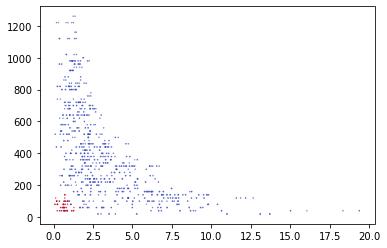

In [4]:
import matplotlib.pyplot as plt
sub = X_train[:,[0,1,2]]  # spatial and temporal distance and max mitosis score, the first three features
plt.scatter(sub[:,0], sub[:,1], c=y_train, s=(- min(sub[:,2]) + sub[:,2])*1, alpha=0.8, cmap='coolwarm')

From the plot, we see that _spatial and temporal correlations_ are strong predictors of the mitosis relationship. However, _mitosis score_, a secondary feature derived from cell cycle classification, does not help much to discern mitosis pairs. We believe this is a result from inaccurate mitosis prediction and should be fixed with increasing training set.

__Find optimal parameters__

In [7]:
C_range = list(map(lambda x:10**x, np.linspace(-1,5,100)))
gamma_range = list(map(lambda x:10**x, np.linspace(-5,1,10)))

#### WARNING: The following grid search require high computing power !!!

In [76]:
# Grid search on best params
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score   
from sklearn.svm import SVC 

def svm_cross_validation(train_x, train_y):       
    #model = SVC(kernel='rbf', probability=True, class_weight='balanced')
    #param_grid = {'C': C_range, 'gamma': gamma_range} 
    model = SVC(kernel='linear', probability=True, class_weight='balanced')    
    param_grid = {'C': C_range}
    grid_search = GridSearchCV(model, param_grid, n_jobs = 2, verbose=1, scoring='f1')
    grid_search.fit(train_x, train_y)
    best_parameters = grid_search.best_estimator_.get_params()
    for para, val in list(best_parameters.items()):
        print(para, val)
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True, class_weight='balanced')
    model.fit(train_x, train_y)
    return model, grid_search.cv_results_

model, results = svm_cross_validation(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
C 0.464158883361278
break_ties False
cache_size 200
class_weight balanced
coef0 0.0
decision_function_shape ovr
degree 3
gamma scale
kernel linear
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False
[0.89867841 0.99559471 0.99118943 0.98678414 0.99557522]


In [77]:
score = results['mean_test_score']
#gamma = results['param_gamma']
c = list(results['param_C'])

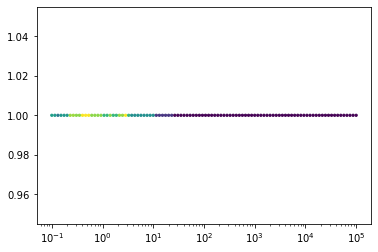

In [89]:
import matplotlib.pyplot as plt
#plt.yscale("log")
plt.xscale("log")
#plt.scatter(x=c, y=gamma, c=score, cmap='hot')
plt.scatter(x=c, y=[1 for _ in range(len(c))], c=score, s=5)

---

### Fit model

In [5]:
c = 5
gamma = 1

In [6]:
# normalize
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [7]:
from sklearn.svm import SVC 
#model = SVC(kernel='rbf', C=100, gamma=0.01, probability=True, class_weight='balanced')    
model = SVC(kernel='linear', C=c, probability=True, class_weight='balanced')    
model.fit(X_train, y_train)

SVC(C=5, class_weight='balanced', kernel='linear', probability=True)

### ROC of model performance (on training set)

In [8]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

In [9]:
y_score_cls = model.predict_proba(X_train)
y_score = []
for i in range(y_score_cls.shape[0]):
    if y_score_cls[i,0] > y_score_cls[i,1]:
        y_score.append(y_score_cls[i,1])
    else:
        y_score.append(y_score_cls[i,0])
fpr, tpr, thresholds = roc_curve(y_train, y_score)

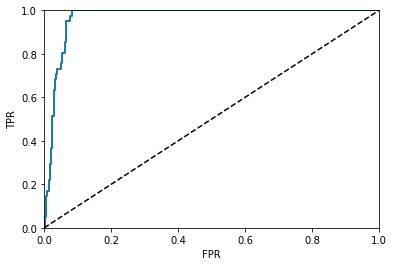

In [10]:
plot_roc_curve(fpr, tpr)
plt.show()

### Visualize the decision boundary (linear kernal only, 2D model)

[_Code Reference (Chinese)_](https://blog.csdn.net/bingbangx/article/details/107856502)

In [11]:
def plot_svc_decision_function(model,ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0],xlim[1],30)
    y = np.linspace(ylim[0],ylim[1],30)
    Y,X = np.meshgrid(y,x) 
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P,colors="k",levels=[-1,0,1],alpha=0.5,linestyles=["--","-","--"]) 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [12]:
model = SVC(kernel='linear', C=c, probability=True, class_weight='balanced')    
model.fit(X_train[:,0:2], y_train)

SVC(C=5, class_weight='balanced', kernel='linear', probability=True)

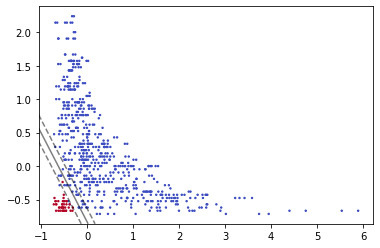

In [21]:
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,s=2,cmap="coolwarm")
plot_svc_decision_function(model)

In [22]:
r = np.exp(-(X_train**2).sum(1))
rlim = np.linspace(min(r),max(r),100)
from mpl_toolkits import mplot3d
def plot_3D(elev=30,azim=30,X=X_train,y=y_train):
    ax = plt.subplot(projection="3d")
    ax.scatter3D(X[:,0],X[:,1],r,c=y,s=50,cmap='rainbow')
    ax.view_init(elev=elev,azim=azim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("r")
    plt.show()
from ipywidgets import interact,fixed
interact(plot_3D,elev=[-60,-30,0,30,60,90,120],azip=(-180,180),X=fixed(X_train),y=fixed(y_train))
plt.show()

interactive(children=(Dropdown(description='elev', index=3, options=(-60, -30, 0, 30, 60, 90, 120), value=30),…

---

__For using SVM model in real tracking environment through `pcnaDeep.refiner.Refiner`__, see [Getting started](getting_started.ipynb).

In [4]:
from pcnaDeep.refiner import Refiner
dt = pd.read_csv('/Users/jefft/Documents/Images/RPE_20200729_s2/refined_corrected_resolved.csv')
r = Refiner(dt.copy(), mode='TRAIN_GT', minM=1, sample_freq=1/20, mt_len=5)
X, y, samples = r.doTrackRefine()
train = pd.DataFrame(X)
train['y'] = y
train.to_csv('/Users/jefft/Documents/Images/RPE_20200729_s2/SVM_train_RPE_cpd.txt', header=0, index=0)
train['par'] = samples[:,0]
train['daug'] = samples[:,1]
train.to_csv('/Users/jefft/Documents/Images/RPE_20200729_s2/SVM_train_lbd_RPE_cpd.txt', header=0, index=0)

Mitosis exit not found for daughter: 41
